In [2]:
# Import những thư viện cần thiết
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Đọc dữ liệu
df = pd.read_csv("international_matches.csv")

In [4]:
df

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           23921 non-null  object 
 1   home_team                      23921 non-null  object 
 2   away_team                      23921 non-null  object 
 3   home_team_continent            23921 non-null  object 
 4   away_team_continent            23921 non-null  object 
 5   home_team_fifa_rank            23921 non-null  int64  
 6   away_team_fifa_rank            23921 non-null  int64  
 7   home_team_total_fifa_points    23921 non-null  int64  
 8   away_team_total_fifa_points    23921 non-null  int64  
 9   home_team_score                23921 non-null  int64  
 10  away_team_score                23921 non-null  int64  
 11  tournament                     23921 non-null  object 
 12  city                           23921 non-null 

In [6]:
# Thay đổi kiểu dữ liệu để chính xác hơn
df['date'] = pd.to_datetime(df['date'])
df = df.replace({'shoot_out': {'Yes': True, 'No': False}})

C:\Users\Admin\AppData\Local\Temp\ipykernel_21204\3958220966.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'shoot_out': {'Yes': True, 'No': False}})


In [7]:
world_cup_teams = ['Qatar', 'Netherlands', 'Senegal', 'Ecuador', 'England', 'USA', 'IR Iran', 'Wales',
                   'Argentina', 'Mexico', 'Poland', 'Saudi Arabia', 'France', 'Denmark', 'Tunisia', 'Australia',
                   'Spain', 'Germany', 'Japan', 'Costa Rica', 'Belgium', 'Croatia', 'Morocco', 'Canada',
                   'Brazil', 'Switzerland', 'Serbia', 'Cameroon', 'Portugal', 'Uruguay', 'Korea Republic', 'Ghana']

In [8]:
# Xóa các kết quả trùng khớp không liên quan
# Giữ nguyên các trận đấu giữa các đội trong World Cup, các trận đấu của họ với các đội có thứ hạng dưới 100
# Giữ trận đấu giữa các đội có thứ hạng dưới 50

df = df[((df['home_team'].isin(world_cup_teams) & df['away_team'].isin(world_cup_teams)) |
                   (df['home_team'].isin(world_cup_teams) & (df['away_team_fifa_rank'] <= 100)) |
                   ((df['home_team_fifa_rank'] <= 100) & df['away_team'].isin(world_cup_teams))|
                   ((df['home_team_fifa_rank'] <= 50) & (df['away_team_fifa_rank'] <= 50)))]
df.reset_index(drop=True, inplace=True)
df.shape

(8653, 25)

In [9]:
# Xóa home_team_continent và away_team_continent vì không có ý nghĩa
df = df.drop(['home_team_continent', 'away_team_continent'], axis = 1)

In [10]:
# Xóa các thuộc tính city, country, neutral_location vì không cần trong quá trình phân tích
df = df.drop(['city', 'country', 'neutral_location'], axis = 1)

In [11]:
df = df.drop(['home_team_goalkeeper_score',
              'away_team_goalkeeper_score'], axis = 1)

In [12]:
df = df.drop(['home_team_mean_defense_score',
              'home_team_mean_offense_score',
              'home_team_mean_midfield_score'], axis = 1)

In [13]:
df = df.drop(['away_team_mean_defense_score',
              'away_team_mean_offense_score',
              'away_team_mean_midfield_score'], axis = 1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8653 entries, 0 to 8652
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         8653 non-null   datetime64[ns]
 1   home_team                    8653 non-null   object        
 2   away_team                    8653 non-null   object        
 3   home_team_fifa_rank          8653 non-null   int64         
 4   away_team_fifa_rank          8653 non-null   int64         
 5   home_team_total_fifa_points  8653 non-null   int64         
 6   away_team_total_fifa_points  8653 non-null   int64         
 7   home_team_score              8653 non-null   int64         
 8   away_team_score              8653 non-null   int64         
 9   tournament                   8653 non-null   object        
 10  shoot_out                    8653 non-null   bool          
 11  home_team_result             8653 non-null 

In [15]:
# Kiểm tra số lượng giá trị null trong mỗi cột
missing_values = df.isna().sum()

# Hiển thị số lượng giá trị null trong mỗi cột
print(missing_values)

date                           0
home_team                      0
away_team                      0
home_team_fifa_rank            0
away_team_fifa_rank            0
home_team_total_fifa_points    0
away_team_total_fifa_points    0
home_team_score                0
away_team_score                0
tournament                     0
shoot_out                      0
home_team_result               0
dtype: int64


In [16]:
# Kiểm tra dữ liệu trùng lặp
df.duplicated().sum()

0

In [17]:
# Tạo các thuộc tính mới để thực hiện phân tích
df['goal_difference'] = df['home_team_score'] - df['away_team_score']
df['rank_difference'] = df['home_team_fifa_rank'] - df['away_team_fifa_rank']
df['Friendly'] = df['tournament'] == 'Friendly'
df['year'] = df['date'].dt.year

In [18]:
df

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,shoot_out,home_team_result,goal_difference,rank_difference,Friendly,year
0,1993-08-08,Bolivia,Uruguay,59,22,0,0,3,1,FIFA World Cup qualification,False,Win,2,37,False,1993
1,1993-08-08,Brazil,Mexico,8,14,0,0,1,1,Friendly,False,Draw,0,-6,True,1993
2,1993-08-08,Ecuador,Venezuela,35,94,0,0,5,0,FIFA World Cup qualification,False,Win,5,-59,False,1993
3,1993-08-08,Paraguay,Argentina,67,5,0,0,1,3,FIFA World Cup qualification,False,Lose,-2,62,False,1993
4,1993-08-11,Sweden,Switzerland,4,3,0,0,1,2,Friendly,False,Lose,-1,1,True,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8648,2022-06-14,Poland,Belgium,26,2,1544,1827,0,1,UEFA Nations League,False,Lose,-1,24,False,2022
8649,2022-06-14,Ukraine,Republic of Ireland,27,47,1535,1449,1,1,UEFA Nations League,False,Draw,0,-20,False,2022
8650,2022-06-14,Chile,Ghana,28,60,1526,1387,0,0,Kirin Cup,True,Lose,0,-32,False,2022
8651,2022-06-14,Japan,Tunisia,23,35,1553,1499,0,3,Kirin Cup,False,Lose,-3,-12,False,2022


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8653 entries, 0 to 8652
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         8653 non-null   datetime64[ns]
 1   home_team                    8653 non-null   object        
 2   away_team                    8653 non-null   object        
 3   home_team_fifa_rank          8653 non-null   int64         
 4   away_team_fifa_rank          8653 non-null   int64         
 5   home_team_total_fifa_points  8653 non-null   int64         
 6   away_team_total_fifa_points  8653 non-null   int64         
 7   home_team_score              8653 non-null   int64         
 8   away_team_score              8653 non-null   int64         
 9   tournament                   8653 non-null   object        
 10  shoot_out                    8653 non-null   bool          
 11  home_team_result             8653 non-null 

In [20]:
# Xuất dữ liệu
df.to_csv('data_daxuly.csv')

# Thực hiện thuật toán

In [21]:
# Import dữ liệu đã được xử lý
matches = pd.read_csv('data_daxuly.csv')
matches

,Unnamed: 0,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,shoot_out,home_team_result,goal_difference,rank_difference,Friendly,year
0,0,1993-08-08,Bolivia,Uruguay,59,22,0,0,3,1,FIFA World Cup qualification,False,Win,2,37,False,1993
1,1,1993-08-08,Brazil,Mexico,8,14,0,0,1,1,Friendly,False,Draw,0,-6,True,1993
2,2,1993-08-08,Ecuador,Venezuela,35,94,0,0,5,0,FIFA World Cup qualification,False,Win,5,-59,False,1993
3,3,1993-08-08,Paraguay,Argentina,67,5,0,0,1,3,FIFA World Cup qualification,False,Lose,-2,62,False,1993
4,4,1993-08-11,Sweden,Switzerland,4,3,0,0,1,2,Friendly,False,Lose,-1,1,True,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8648,8648,2022-06-14,Poland,Belgium,26,2,1544,1827,0,1,UEFA Nations League,False,Lose,-1,24,False,2022
8649,8649,2022-06-14,Ukraine,Republic of Ireland,27,47,1535,1449,1,1,UEFA Nations League,False,Draw,0,-20,False,2022
8650,8650,2022-06-14,Chile,Ghana,28,60,1526,1387,0,0,Kirin Cup,True,Lose,0,-32,False,2022
8651,8651,2022-06-14,Japan,Tunisia,23,35,1553,1499,0,3,Kirin Cup,False,Lose,-3,-12,False,2022


In [22]:
# Xóa thuộc tính Unnamed: 0
matches = matches.drop(['Unnamed: 0'], axis = 1)

In [23]:
matches

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,away_team_score,tournament,shoot_out,home_team_result,goal_difference,rank_difference,Friendly,year
0,1993-08-08,Bolivia,Uruguay,59,22,0,0,3,1,FIFA World Cup qualification,False,Win,2,37,False,1993
1,1993-08-08,Brazil,Mexico,8,14,0,0,1,1,Friendly,False,Draw,0,-6,True,1993
2,1993-08-08,Ecuador,Venezuela,35,94,0,0,5,0,FIFA World Cup qualification,False,Win,5,-59,False,1993
3,1993-08-08,Paraguay,Argentina,67,5,0,0,1,3,FIFA World Cup qualification,False,Lose,-2,62,False,1993
4,1993-08-11,Sweden,Switzerland,4,3,0,0,1,2,Friendly,False,Lose,-1,1,True,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8648,2022-06-14,Poland,Belgium,26,2,1544,1827,0,1,UEFA Nations League,False,Lose,-1,24,False,2022
8649,2022-06-14,Ukraine,Republic of Ireland,27,47,1535,1449,1,1,UEFA Nations League,False,Draw,0,-20,False,2022
8650,2022-06-14,Chile,Ghana,28,60,1526,1387,0,0,Kirin Cup,True,Lose,0,-32,False,2022
8651,2022-06-14,Japan,Tunisia,23,35,1553,1499,0,3,Kirin Cup,False,Lose,-3,-12,False,2022


# ID3

In [24]:
matches['date'] = pd.to_datetime(matches['date'])

In [25]:
matches = matches.select_dtypes(include=np.number)

In [26]:
for col in matches.columns:
    matches[col] = pd.to_numeric(matches[col], errors='coerce')

<Axes: >

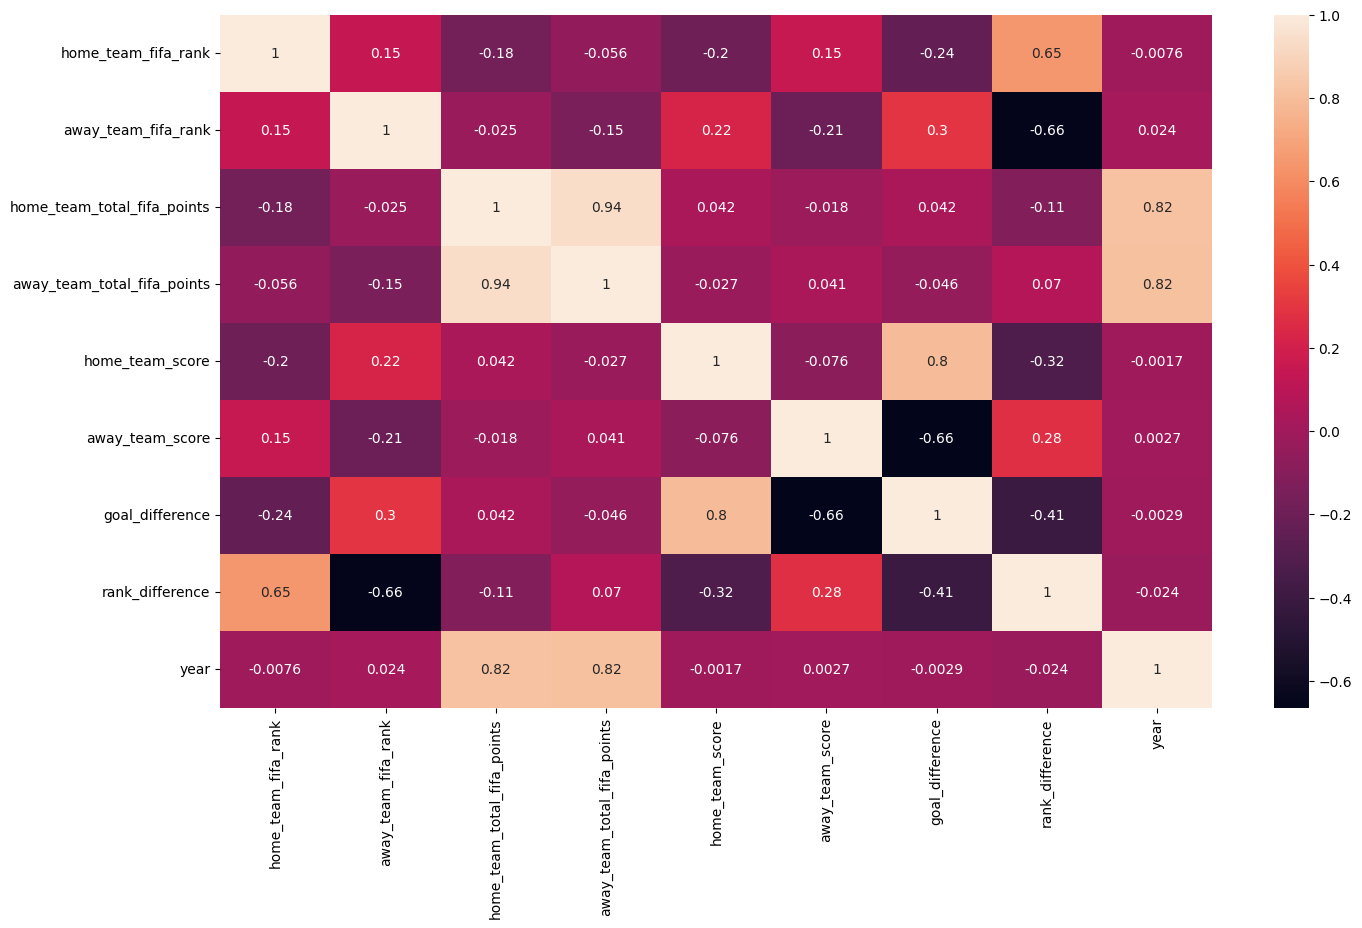

In [27]:
plt.figure(figsize=(16,9))
sns.heatmap(matches.corr(method='pearson'),annot=True)

Các cặp thuộc tính có độ tương quan cao:

home_team_fifa_rank và away_team_fifa_rank -> bỏ away_team_fifa_rank

home_team_total_fifa_points và away_team_total_fifa_points -> bỏ away_team_total_fifa_points

In [28]:
columns = ['away_team_fifa_rank', 'away_team_total_fifa_points']

matches.drop(columns, inplace=True, axis=1)

<Axes: >

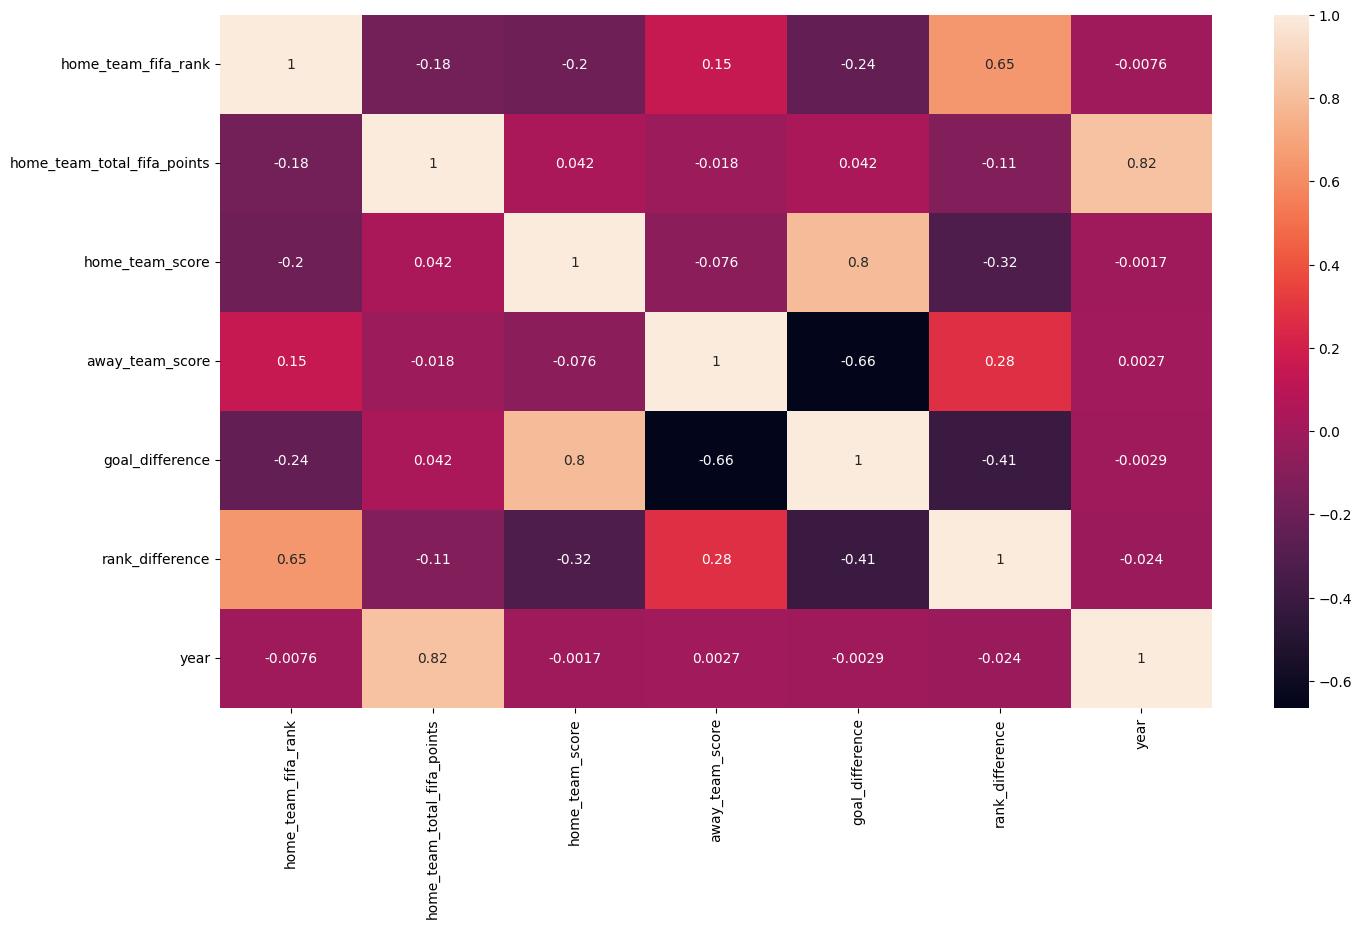

In [29]:
plt.figure(figsize=(16,9))
sns.heatmap(matches.corr(method='pearson'),annot=True)

In [30]:
data = matches.copy()
data.dropna(subset=["goal_difference"], inplace=True)

In [31]:
# Tách dữ liệu feature
X = data.drop('goal_difference', axis=1)

In [32]:
# Tách dữ liệu chứa thuộc tính quyết định
y = data['goal_difference']

In [33]:
print("Dữ liệu feature:")
print(X.head())

Dữ liệu feature:
   home_team_fifa_rank  home_team_total_fifa_points  home_team_score  \
0                   59                            0                3   
1                    8                            0                1   
2                   35                            0                5   
3                   67                            0                1   
4                    4                            0                1   

   away_team_score  rank_difference  year  
0                1               37  1993  
1                1               -6  1993  
2                0              -59  1993  
3                3               62  1993  
4                2                1  1993  


In [34]:
print("\nDữ liệu chứa thuộc tính quyết định:")
print(y.head())


Dữ liệu chứa thuộc tính quyết định:
0    2
1    0
2    5
3   -2
4   -1
Name: goal_difference, dtype: int64


In [35]:
# Chia dữ liệu thành tập train và test với tỉ lệ 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
# Xây dựng cây ID3
# Đặt time chạy thuật toán
start_ID3 =time.time()
clf1 = tree.DecisionTreeClassifier(criterion="entropy", random_state=0)
clf1.fit(X_train, y_train)
end_ID3=time.time()
thoigian1=timedelta(seconds=round(end_ID3-start_ID3,4))
print(thoigian1)

0:00:00.011000


In [37]:
clf1= tree.DecisionTreeClassifier(criterion="entropy", random_state=0)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [38]:
tree_pred1 = clf1.predict(X_test)
tree_score1 = metrics.accuracy_score(y_test, tree_pred1)
print("Độ chính xác: ",tree_score1)
print("Report:",metrics.classification_report(y_test, tree_pred1))

Độ chính xác:  0.9984591679506933
Report:               precision    recall  f1-score   support

          -6       0.00      0.00      0.00         0
          -5       1.00      0.89      0.94         9
          -4       1.00      1.00      1.00        24
          -3       1.00      1.00      1.00        80
          -2       1.00      1.00      1.00       158
          -1       1.00      1.00      1.00       391
           0       1.00      1.00      1.00       675
           1       1.00      1.00      1.00       620
           2       1.00      1.00      1.00       347
           3       1.00      1.00      1.00       154
           4       1.00      1.00      1.00        82
           5       1.00      1.00      1.00        36
           6       1.00      1.00      1.00        14
           7       1.00      0.50      0.67         4
           8       0.50      1.00      0.67         2

    accuracy                           1.00      2596
   macro avg       0.90      0.89     

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [39]:
#tính toán ma trận nhầm lẫn
tree_cm1 = metrics.confusion_matrix(y_test, tree_pred1)

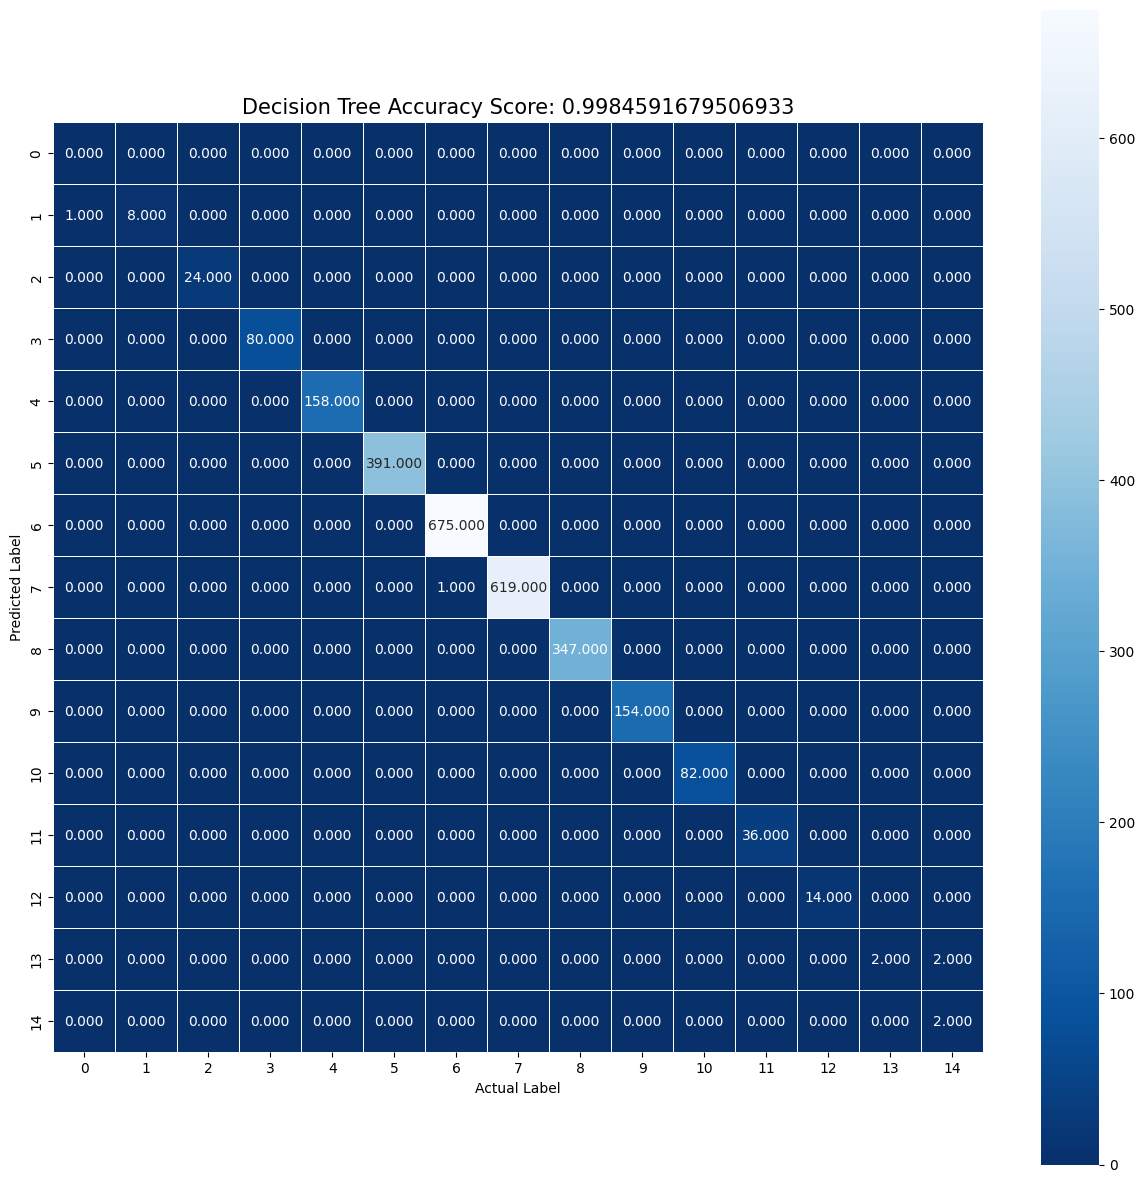

In [40]:
plt.figure(figsize=(15,15))
sns.heatmap(tree_cm1, annot=True, fmt=".3f", linewidth=0.5, square=True, cmap="Blues_r");
plt.xlabel("Actual Label");
plt.ylabel("Predicted Label");
title = 'Decision Tree Accuracy Score: {0}'.format(tree_score1)
plt.title(title, size=15);

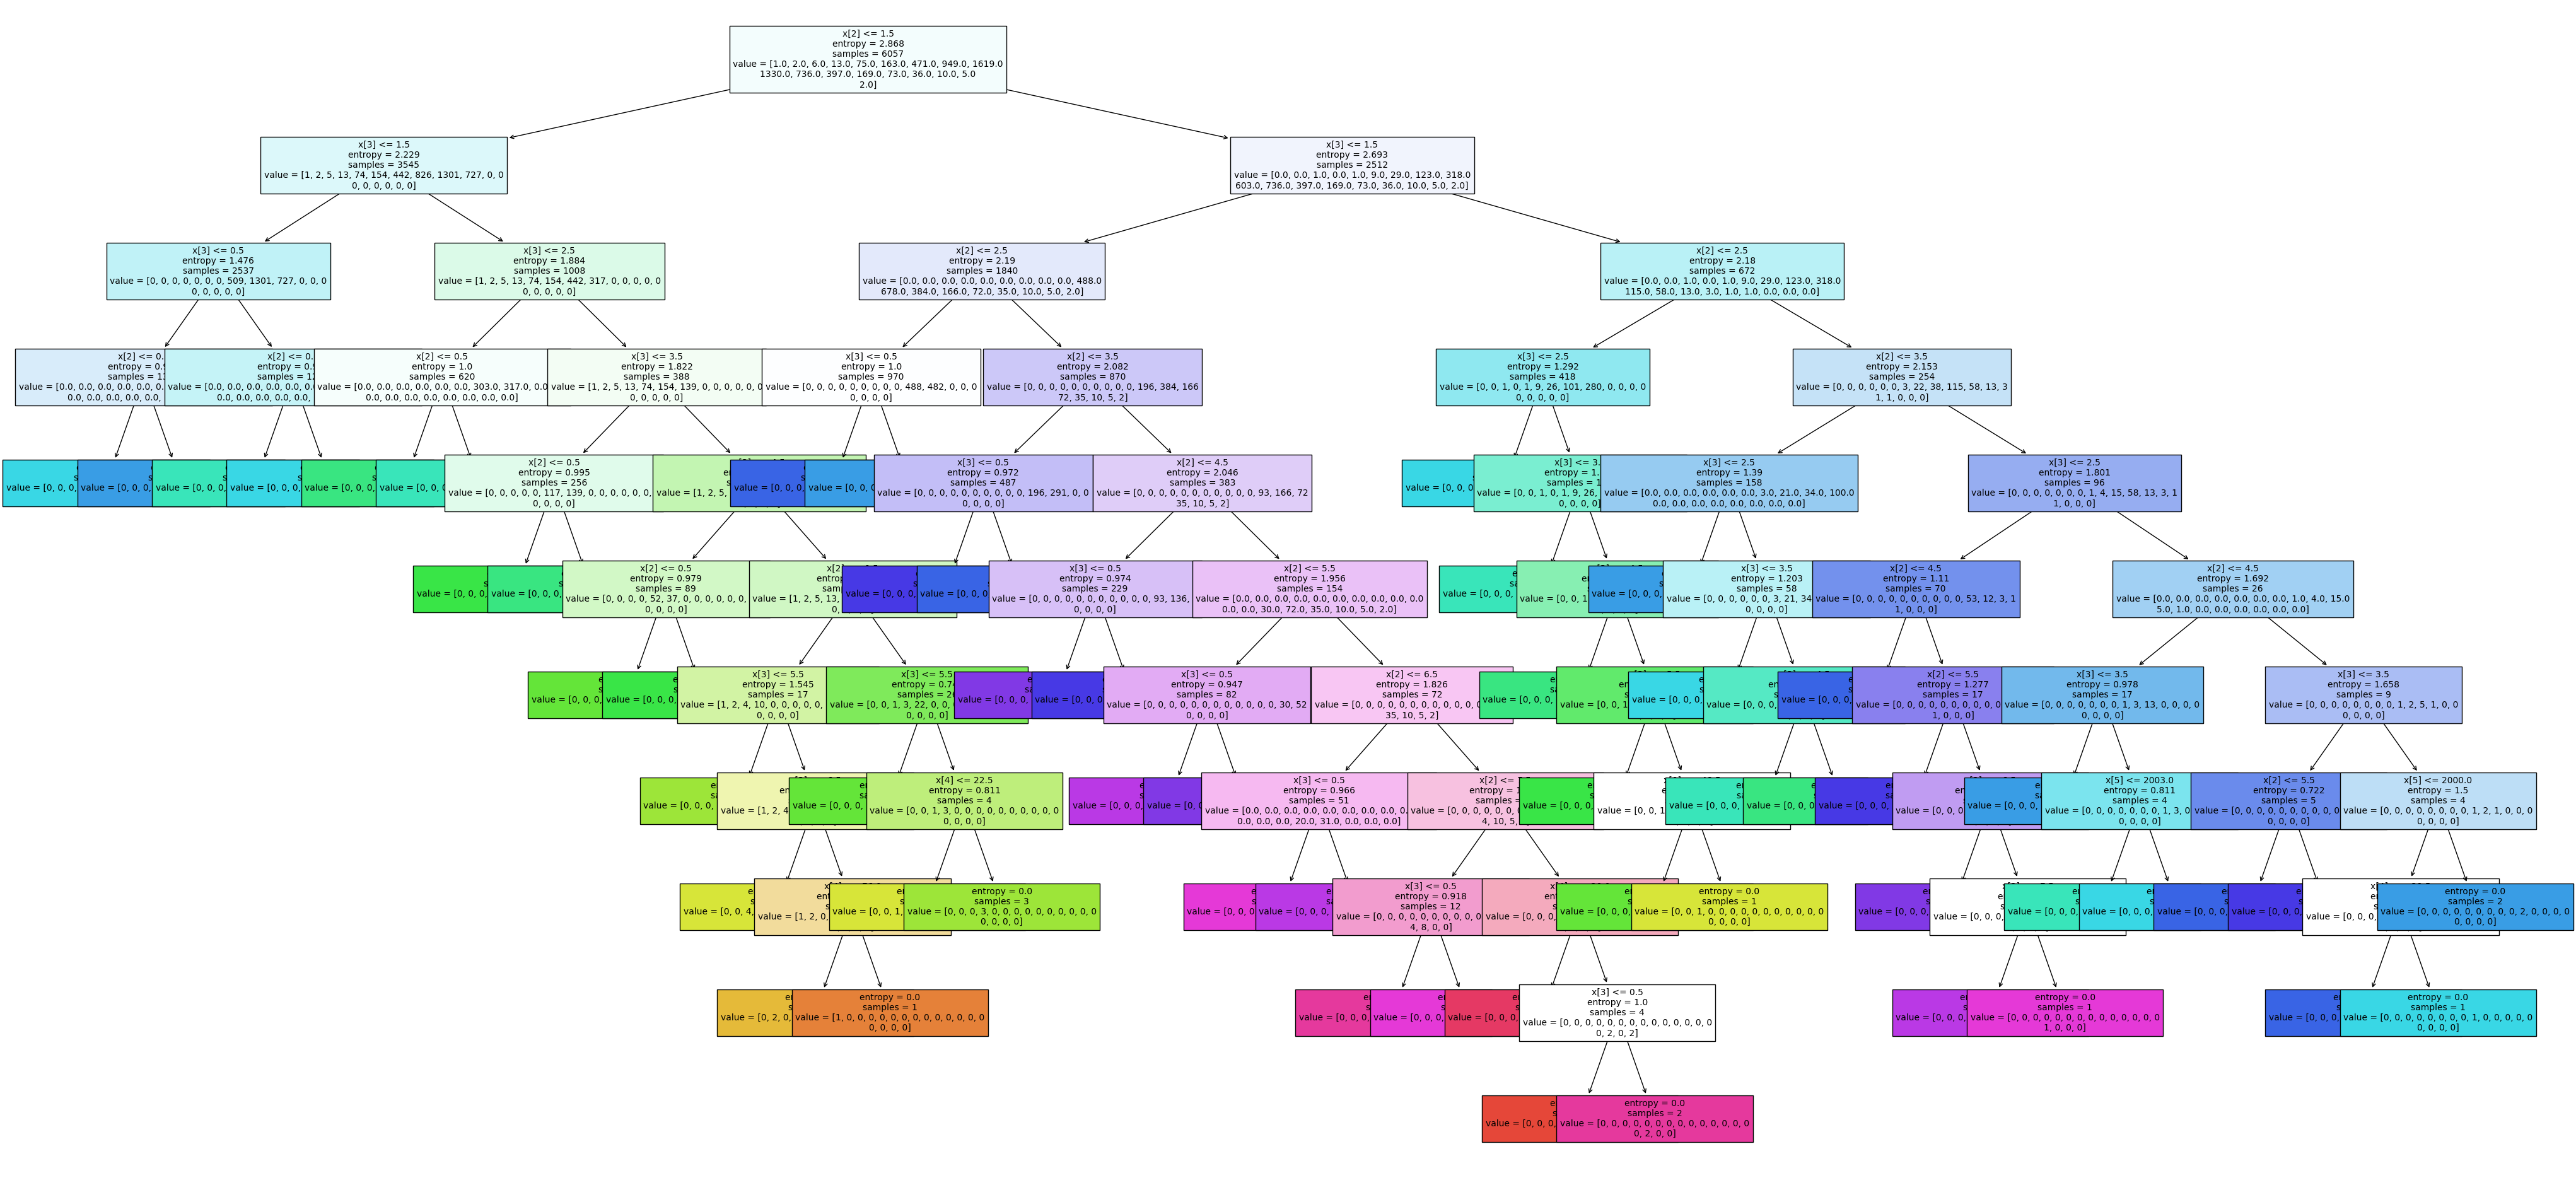

In [41]:
# Plot the decision tree
fig, ax = plt.subplots(figsize=(50, 24))
tree.plot_tree(clf1, filled=True, fontsize=10)
plt.savefig('decision_tree', dpi=100)
plt.show()

# Naive Bayes

In [42]:
# Kiểm tra thời gian chạy thuật toán
start_Bayes = time.time()
gnb = GaussianNB()
bayes_pred = gnb.fit(X_train, y_train).predict(X_test)
end_Bayes = time.time()
thoigian3 = timedelta(seconds=round(end_Bayes - start_Bayes, 4))
print(thoigian3)

0:00:00.006000


In [43]:
# Chạy thuật toán
bayes_score = metrics.accuracy_score(y_test, bayes_pred)
print("Độ chính xác:", bayes_score)
print("Report:", metrics.classification_report(y_test, bayes_pred))

Độ chính xác: 0.6224961479198767
Report:               precision    recall  f1-score   support

          -6       0.00      0.00      0.00         0
          -5       0.50      0.33      0.40         9
          -4       0.61      0.46      0.52        24
          -3       0.52      0.19      0.28        80
          -2       0.50      0.42      0.46       158
          -1       0.57      0.46      0.51       391
           0       0.64      0.84      0.73       675
           1       0.63      0.74      0.68       620
           2       0.55      0.33      0.42       347
           3       0.85      0.72      0.78       154
           4       0.81      0.67      0.73        82
           5       0.43      0.64      0.52        36
           6       0.70      0.50      0.58        14
           7       0.60      0.75      0.67         4
           8       1.00      1.00      1.00         2

    accuracy                           0.62      2596
   macro avg       0.59      0.54      

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

# CART

In [44]:
# Kiểm tra thời gian chạy thuật toán
start_CART = time.time()
clf2 = tree.DecisionTreeClassifier(criterion='gini', random_state = 0)
clf2.fit(X_train, y_train)
end_CART = time.time()
thoigian2 = timedelta(seconds = round(end_CART - start_CART, 4))
print(thoigian2)

0:00:00.008000


In [45]:
# Chạy thuật toán
tree_pred2 = clf2.predict(X_test)
tree_score2 = metrics.accuracy_score(y_test, tree_pred2)
print("Độ chính xác:", tree_score2)
print("Report:", metrics.classification_report(y_test, tree_pred2))

Độ chính xác: 0.9984591679506933
Report:               precision    recall  f1-score   support

          -6       0.00      0.00      0.00         0
          -5       1.00      0.78      0.88         9
          -4       1.00      1.00      1.00        24
          -3       1.00      1.00      1.00        80
          -2       1.00      1.00      1.00       158
          -1       1.00      1.00      1.00       391
           0       1.00      1.00      1.00       675
           1       1.00      1.00      1.00       620
           2       1.00      1.00      1.00       347
           3       1.00      1.00      1.00       154
           4       1.00      1.00      1.00        82
           5       1.00      1.00      1.00        36
           6       0.93      1.00      0.97        14
           7       1.00      0.75      0.86         4
           8       1.00      1.00      1.00         2

    accuracy                           1.00      2596
   macro avg       0.93      0.90      

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [46]:
# Tính ma trận nhầm lẫn
tree_cm2 = metrics.confusion_matrix(y_test, tree_pred2)

Text(0.5, 1.0, 'Decision Tree Accuracy Score:0.9984591679506933')

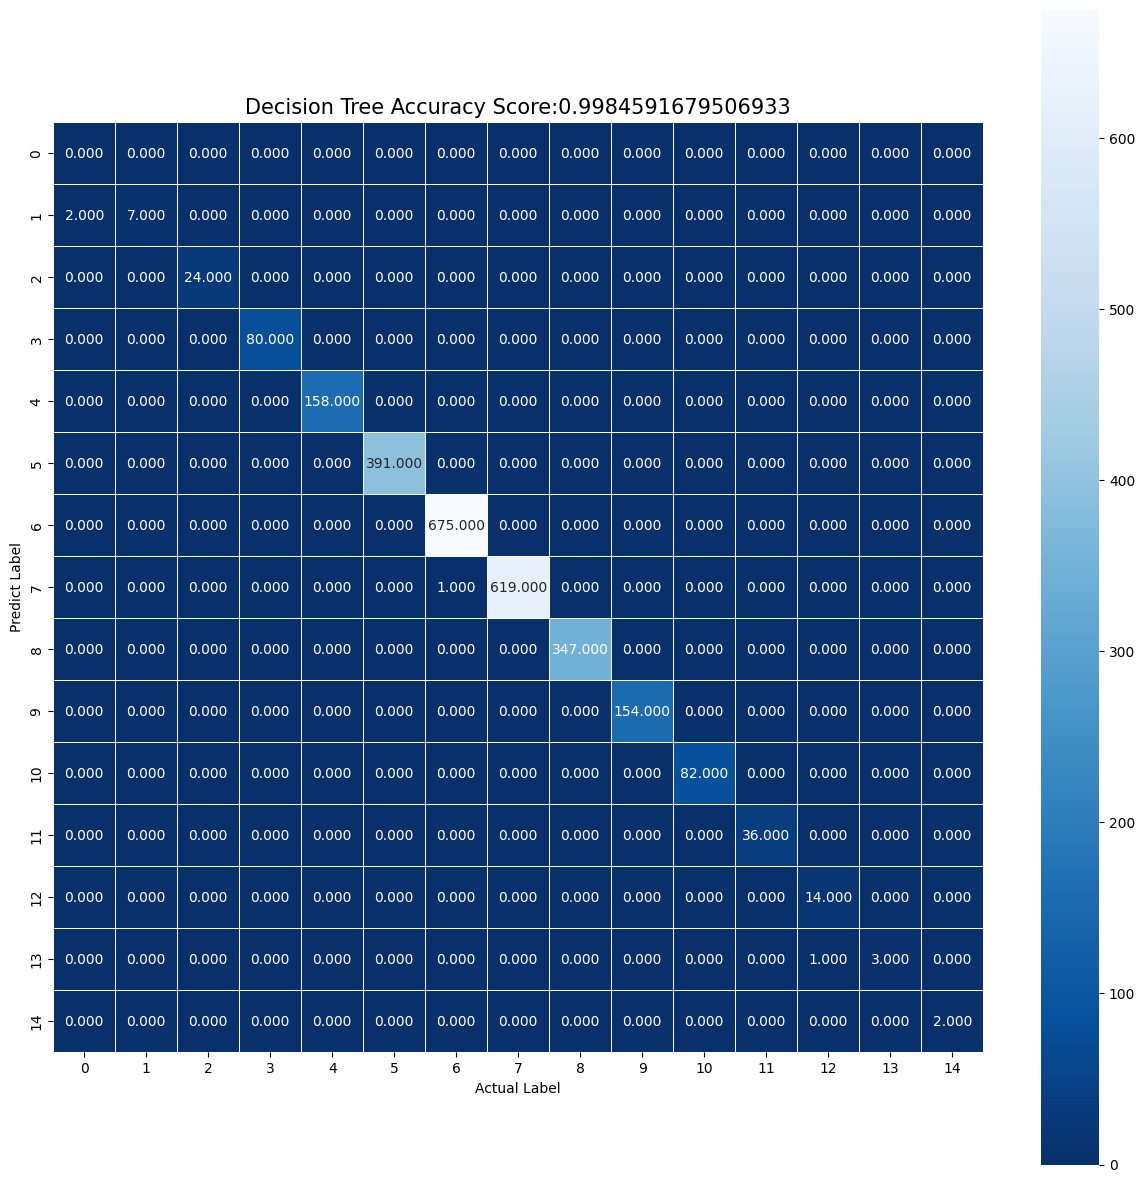

In [47]:
# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(15, 15))
sns.heatmap(tree_cm2, annot = True, fmt = '.3f', linewidth = .5, square = True, cmap = 'Blues_r')
plt.xlabel('Actual Label')
plt.ylabel('Predict Label')
title = 'Decision Tree Accuracy Score:{0}'.format(tree_score2)
plt.title(title, size=15)

# Random Forest

In [48]:
# Kiểm tra thời gian chạy thuật toán
start_RF = time.time()
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
end_RF = time.time()
thoigian4 = timedelta(seconds = round(end_RF - start_RF, 4))
print(thoigian4)

0:00:00.486100


In [49]:
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.9826656394453005


# Đánh giá thuật toán

C:\Users\Admin\AppData\Local\Temp\ipykernel_21204\3049506455.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(end_ID3-start_ID3, bins=10, label = 'Thuật toán ID3', kde = False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21204\3049506455.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.di

Text(0.5, 1.0, 'Thời gian chạy của 3 thuật toán')

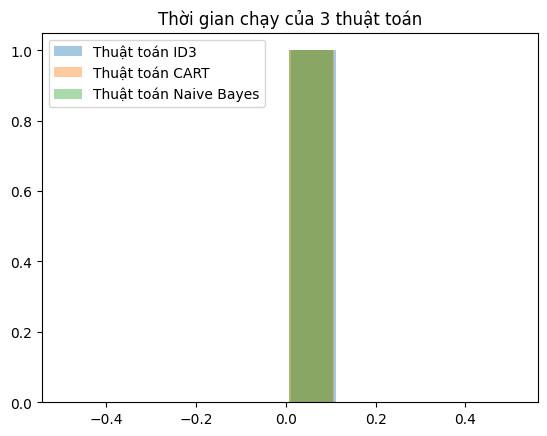

In [50]:
# Đo thời gian của 3 thuật toán
ax = sns.distplot(end_ID3-start_ID3, bins=10, label = 'Thuật toán ID3', kde = False)
ax = sns.distplot(end_CART-start_CART, bins=10, label = 'Thuật toán CART', kde = False)
ax = sns.distplot(end_Bayes-start_Bayes, bins=10, label = 'Thuật toán Naive Bayes', kde = False)
ax.legend()
ax.set_title('Thời gian chạy của 3 thuật toán')

C:\Users\Admin\AppData\Local\Temp\ipykernel_21204\80413065.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(tree_score1, bins=10, label = 'Thuật toán ID3', kde = False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_21204\80413065.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(tre

Text(0.5, 1.0, 'Độ chính xác của 3 thuật toán')

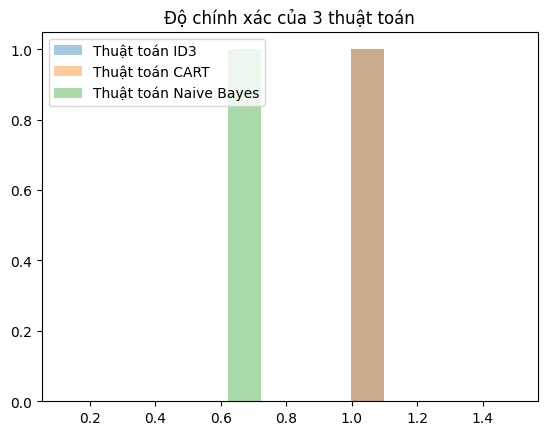

In [51]:
# Đo độ chính xác của 3 thuật toán
ax = sns.distplot(tree_score1, bins=10, label = 'Thuật toán ID3', kde = False)
ax = sns.distplot(tree_score2, bins=10, label = 'Thuật toán CART', kde = False)
ax = sns.distplot(bayes_score, bins=10, label = 'Thuật toán Naive Bayes', kde = False)
ax.legend()
ax.set_title('Độ chính xác của 3 thuật toán')

# Dự báo

In [52]:
# Load the training dataset from the 'data' DataFrame
X_train = data.drop('goal_difference', axis=1)
y_train = data['goal_difference']

In [53]:
# Load the testing dataset from the 'test_data.csv' file
test1 = pd.read_csv('test_data.csv')
test1 = test1.drop(['Unnamed: 0'], axis = 1)

In [54]:
# Ensure consistent feature names between training and testing data
X_test = test1.drop('goal_difference', axis=1)
y_test = test1['goal_difference']

In [55]:
# Xây dựng cây ID3
# Đặt time chạy thuật toán
start_ID3 = time.time()
clf1 = tree.DecisionTreeClassifier(criterion="entropy", random_state=0)
clf1.fit(X_train, y_train)
end_ID3=time.time()
thoigian1=timedelta(seconds=round(end_ID3-start_ID3,4))
print(thoigian1)

0:00:00.014000


In [56]:
clf1= tree.DecisionTreeClassifier(criterion="entropy", random_state=0)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [58]:
tree_pred1 = clf1.predict(X_test)
tree_score1 = metrics.accuracy_score(y_test, tree_pred1)
print("Report:",metrics.classification_report(y_test, tree_pred1))

Report:               precision    recall  f1-score   support

          -8       1.00      1.00      1.00         1
          -7       1.00      1.00      1.00         2
          -6       1.00      1.00      1.00         6
          -5       1.00      1.00      1.00        22
          -4       1.00      1.00      1.00        99
          -3       1.00      1.00      1.00       243
          -2       1.00      1.00      1.00       629
          -1       1.00      1.00      1.00      1340
           0       1.00      1.00      1.00      2294
           1       1.00      1.00      1.00      1950
           2       1.00      1.00      1.00      1083
           3       1.00      1.00      1.00       551
           4       1.00      1.00      1.00       251
           5       1.00      1.00      1.00       109
           6       1.00      1.00      1.00        50
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00         7
           9       

In [59]:
#tính toán ma trận nhầm lẫn
tree_cm1 = metrics.confusion_matrix(y_test, tree_pred1)

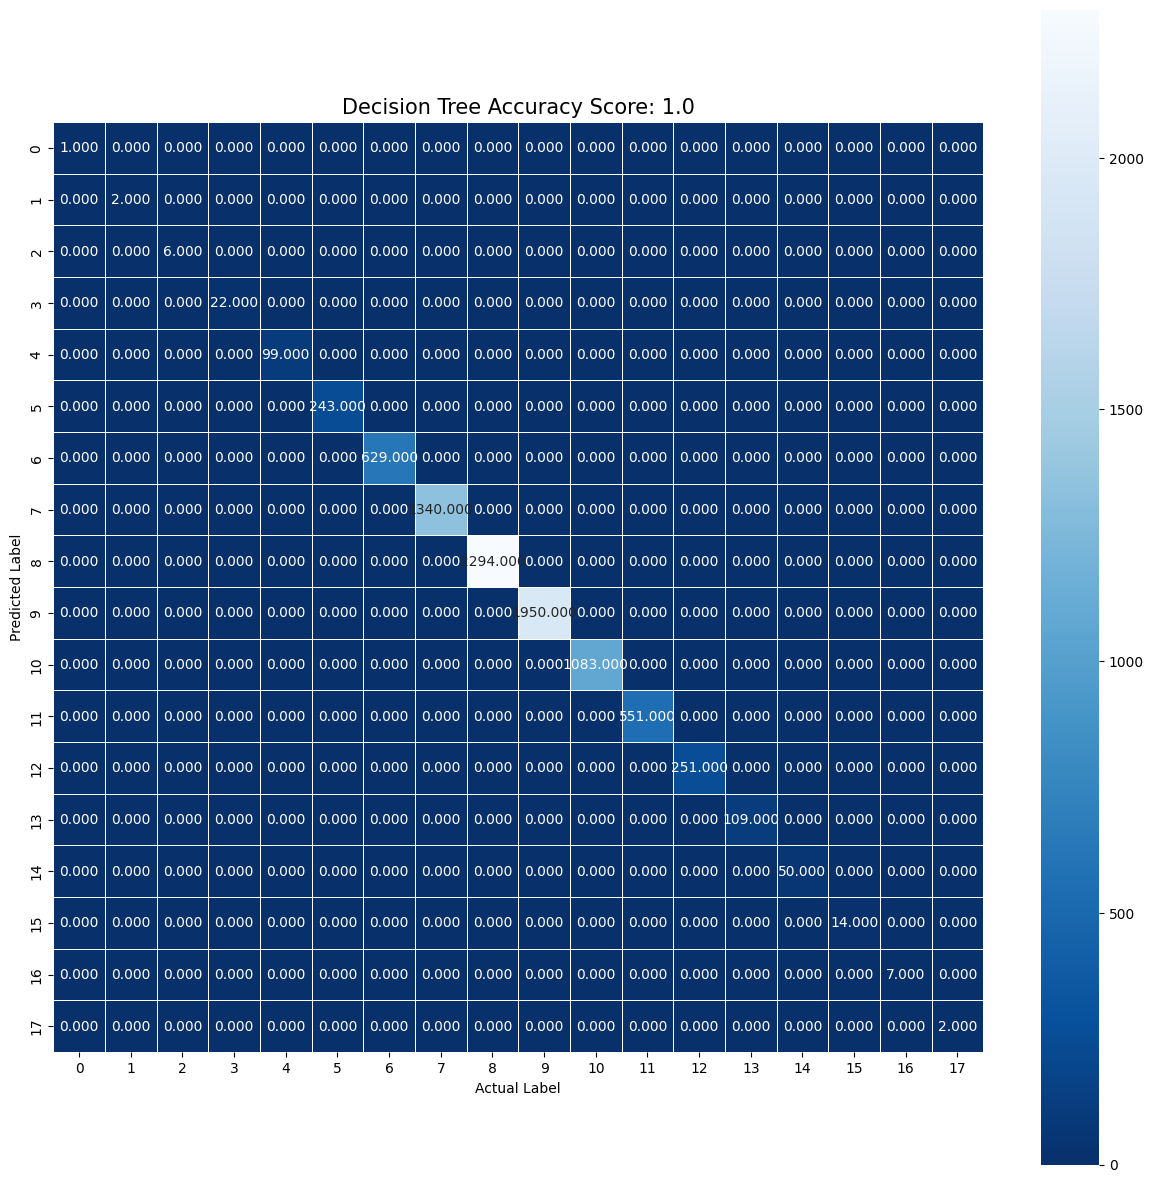

In [60]:
plt.figure(figsize=(15,15))
sns.heatmap(tree_cm1, annot=True, fmt=".3f", linewidth=0.5, square=True, cmap="Blues_r");
plt.xlabel("Actual Label");
plt.ylabel("Predicted Label");
title = 'Decision Tree Accuracy Score: {0}'.format(tree_score1)
plt.title(title, size=15);

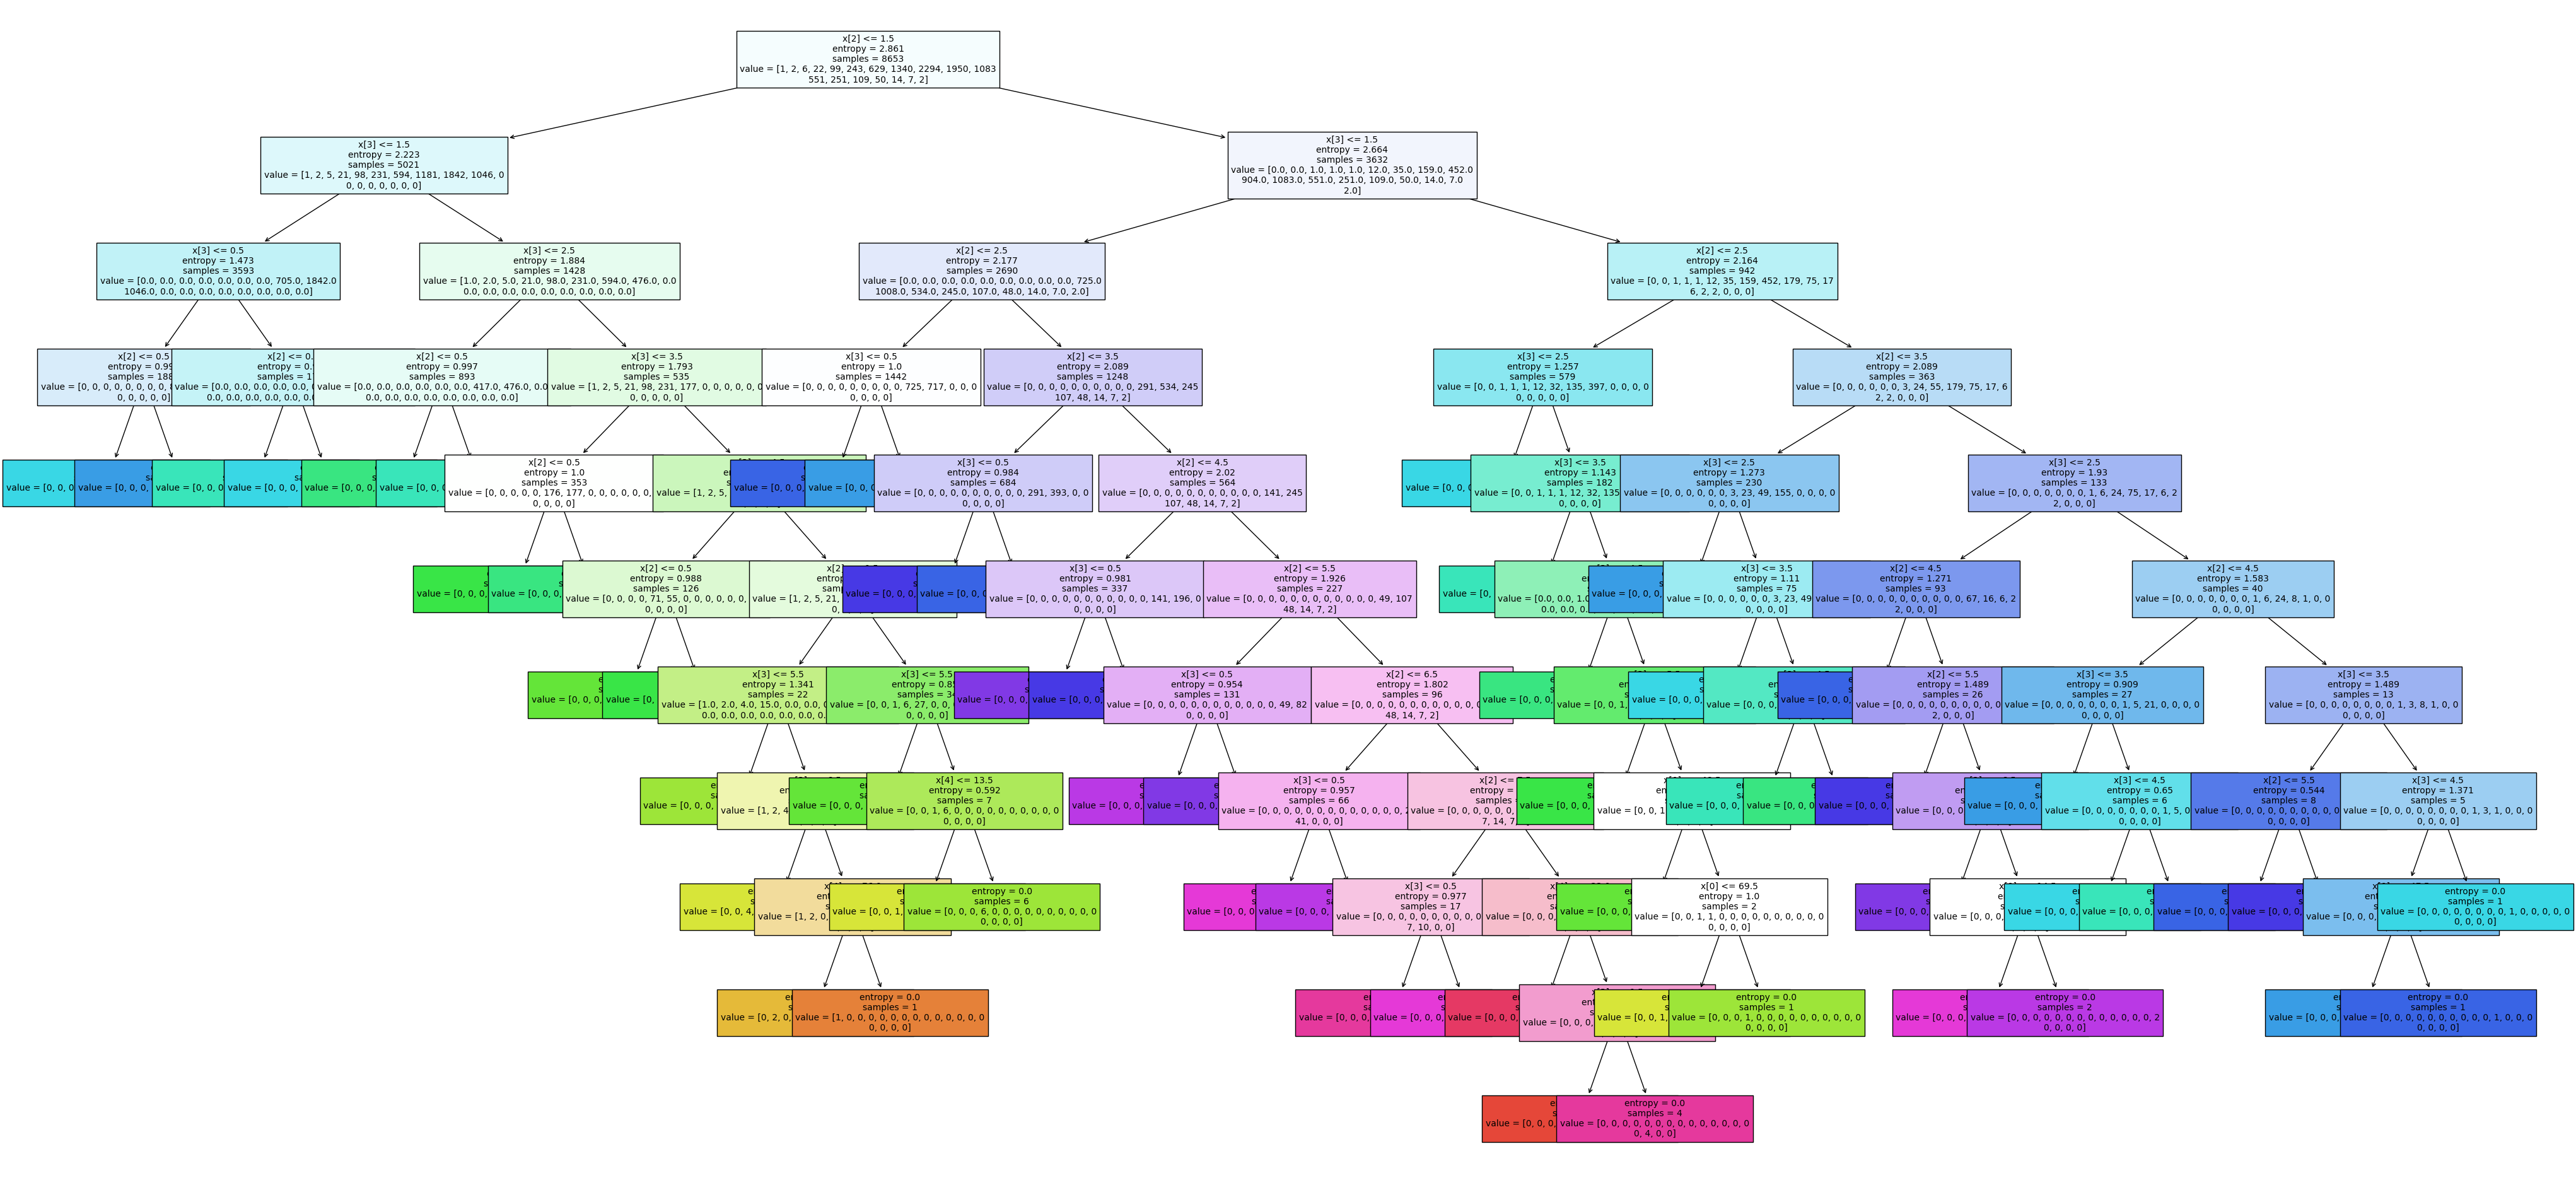

In [61]:
# Plot the decision tree
fig, ax = plt.subplots(figsize=(50, 24))
tree.plot_tree(clf1, filled=True, fontsize=10)
plt.savefig('decision_tree', dpi=100)
plt.show()